## Code for NLP coursework on stance prediction of fake news detection

Using data from: https://github.com/FakeNewsChallenge/fnc-1

Using TF-IDF Vectorizer, SVM, MLP, metrics, cross validation and grid search from: https://scikit-learn.org/stable/

Using PyTorch for LSTM: https://pytorch.org/

Using HuggingFace Transformers for BERT from: https://huggingface.co/transformers/

Adapted BERT code from: https://mccormickml.com/2019/07/22/BERT-fine-tuning/, https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

Adapted FNC scorer from: https://github.com/FakeNewsChallenge/fnc-1/blob/master/scorer.py

Adapted LSTM code from: https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0, https://colab.research.google.com/drive/1cpn6pk2J4liha9jgDLNWhEWeWJb2cdch?usp=sharing


In [1]:
# Import libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torchtext.vocab import Vectors, GloVe
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import logging
from transformers import get_linear_schedule_with_warmup
from collections import defaultdict
import time
import datetime
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read files
bodies = pd.read_csv('train_bodies.csv', sep = ',', index_col = 0)
stances = pd.read_csv('train_stances.csv', sep = ',')
test_bodies = pd.read_csv('competition_test_bodies.csv', sep = ',', index_col = 0)
test_stances = pd.read_csv('competition_test_stances.csv', sep = ',')

# Merge into one DataFrame
dataset = bodies.merge(stances, how ='left', on="Body ID")
test_data = test_bodies.merge(test_stances, how ='left', on="Body ID")

# Inspect DataFrames
display (dataset.head())
display (test_data.head())


,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


,Body ID,articleBody,Headline,Stance
0,1,Al-Sisi has denied Israeli reports stating tha...,Apple installing safes in-store to protect gol...,unrelated
1,1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree
2,1,Al-Sisi has denied Israeli reports stating tha...,Apple to keep gold Watch Editions in special i...,unrelated
3,1,Al-Sisi has denied Israeli reports stating tha...,Apple Stores to Keep Gold “Edition” Apple Watc...,unrelated
4,1,Al-Sisi has denied Israeli reports stating tha...,South Korean woman's hair 'eaten' by robot vac...,unrelated


In [3]:
# generate labels for related/unrelated classification
def generate_label(line):
    if line['Stance'] == 'unrelated':
        return 0
    elif line['Stance'] == 'agree':
        return 1
    elif line['Stance'] == 'disagree':
        return 1
    elif line['Stance'] == 'discuss':
        return 1

In [4]:
# generate labels for agree/disagree/discuss classification
def related_label(line):
    if line['Stance'] == 'agree':
        return 0
    elif line['Stance'] == 'disagree':
        return 1
    elif line['Stance'] == 'discuss':
        return 2
    else:
        return 3

In [5]:
# Add binary labels column to DataFrame for related/unrelated classification
dataset['Labels'] = dataset.apply (lambda line: generate_label(line), axis=1)
labels = dataset['Labels']

# Add integer labels column to DataFrame for agree/disagree/discuss classification
dataset['Related_Label'] = dataset.apply (lambda line: related_label(line), axis=1)

# Inspect DataFrame
display (dataset.head())

,Body ID,articleBody,Headline,Stance,Labels,Related_Label
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated,0,3
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated,0,3
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated,0,3
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated,0,3
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated,0,3


### Feature Extraction

In [6]:
# creates list of English stop words
stop = stopwords.words('english')

# keeps stop words that may help classification (those with negative connotations)
include = ['against','because','no','not',"don't","aren't","couldn't","didn't","doesn't","hadn't","hasn't","haven't","mustn't","shouldn't","wasn't","weren't","won't","wouldn't"]
for word in include:
    stop.remove(word)

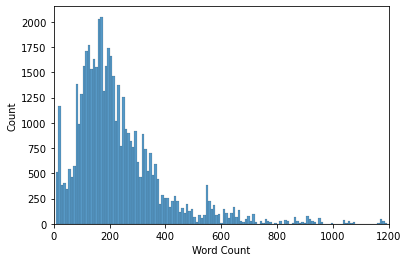

In [7]:
# reading headlines and bodies from dataset
headlines = list(dataset['Headline'])
articles = list(dataset['articleBody'])

# generating full examples to read into vectorizer for TF-IDF 
# cosine similarities vocab
vocab_examples = [headlines[i]+articles[i] for i in range(len(headlines))]
# tf-idf vocab with separation token added to distinguish between headline and body
examples = [headlines[i]+" [BRK] "+articles[i] for i in range(len(headlines))]

# length to truncate examples to
truncation_length = 100

# plotting number of words in each example
lengths = []
new_examples = []
for example in examples:
    example_words = example.split()
    # removing stop words from examples
    filtered_words = [word for word in example_words if not word.lower() in stop]
    lengths.append(len(filtered_words))
    # truncate example to fixed length
    filtered_words = filtered_words[:truncation_length]
    newline = " ".join(filtered_words)
    new_examples.append(newline)
examples = new_examples
sns.histplot(lengths)
plt.xlim([0,1200]);
plt.xlabel('Word Count');

In [8]:
# balancing training examples for related and unrelated classes

balance = False
if balance:
    count = 0
    balanced_labels = []
    balanced_examples = []
    for i in range(len(labels)):
        if (labels[i] == 0 and count<=13427) or labels[i] == 1:
            balanced_labels.append(labels[i])
            balanced_examples.append(examples[i])
            if labels[i] != 1:
                count+=1
    examples = balanced_examples
    labels = balanced_labels

In [9]:
# shuffle examples and labels
shuffled_labels = labels
shuffle = True
if shuffle:
    shuffled = list(zip(examples,labels))
    random.shuffle(shuffled)
    examples,shuffled_labels = zip(*shuffled)

In [10]:
# TF-IDF
    
# fit vectorizer using vocabulary in headlines and bodies too calculate cosine similarities
cosine_vectorizer = TfidfVectorizer(stop_words = stop)
cosine_vectorizer.fit(vocab_examples)

# fit vectorizer using vocabulary in headlines and bodies including new ' [BRK] ' token for tfidf representation
tf_vectorizer = TfidfVectorizer(stop_words = stop)
tf_examples = tf_vectorizer.fit_transform(examples)

In [11]:
# transform headlines and bodies to tf-idf representation
tf_headlines = cosine_vectorizer.transform(headlines)
tf_bodies = cosine_vectorizer.transform(articles)

# get cosine similarities with dot product
similarities = []
for i in range(tf_headlines.shape[0]):
    similarity = linear_kernel(tf_headlines[i], tf_bodies[i])
    similarities.append(similarity[0])

In [12]:
# BERT

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# truncate/pad sequences to first 100 tokens
MAX_LEN=100

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for i in range(len(headlines)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        headlines[i],                      # Sentences to encode.
                        articles[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_tensor = torch.cat(input_ids, dim=0)
attention_masks_tensor = torch.cat(attention_masks, dim=0)
labels_tensor = torch.tensor(labels)

# Examining tokenization
print("vocab size:",tokenizer.vocab_size)

Loading BERT tokenizer...
vocab size: 30522


### Loading/tranforming test data and metrics for results

In [13]:
# Creating test examples for tf-idf and cosine similarity

# load test data
test_headlines = list(test_data['Headline'])
test_articles = list(test_data['articleBody'])
test_examples = [test_headlines[i]+" [BRK] "+test_articles[i] for i in range(len(test_headlines))]

test_data['Labels'] = test_data.apply (lambda line: generate_label(line), axis=1)
test_labels = test_data['Labels']

# transform into tf-idf representation
tf_test_headlines = cosine_vectorizer.transform(test_headlines)
tf_test_bodies = cosine_vectorizer.transform(test_articles)

# get cosine similarities with dot product
test_similarities = []
for i in range(tf_test_headlines.shape[0]):
    similarity = linear_kernel(tf_test_headlines[i], tf_test_bodies[i])
    test_similarities.append(similarity[0])

# transform headlines and articles to tf-idf representation
tf_test_examples = tf_vectorizer.transform(test_examples)

In [14]:
# Transforming test examples to BERT embedding

test_input_ids = []
test_attention_masks = []
for i in range(len(test_headlines)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        test_headlines[i],                      # Sentences to encode.
                        test_articles[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])
    
# Convert the lists into tensors.
test_input_ids_tensor = torch.cat(test_input_ids, dim=0)
test_attention_masks_tensor = torch.cat(test_attention_masks, dim=0)
test_labels_tensor = torch.tensor(test_labels)

In [15]:
# report accuracy, macro-averaged F1 score and confusion matrix
def plot_matrix(true_labels,predictions):
    print("Accuracy:",round(100*accuracy_score(true_labels,predictions),2),"%")
    print("F1 Score:",round(100*f1_score(true_labels,predictions,average='macro'),2),"%")
    cf_matrix = confusion_matrix(true_labels,predictions)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    cf_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Unrelated','Related'], index=['Unrelated','Related'])
    matrix = matrix.rename_axis("True Label")
    matrix = matrix.rename_axis("Predicted Label",axis="columns")
    try:
        cf_labels = np.asarray(cf_labels).reshape(2,2)
        sns.heatmap(matrix, annot=cf_labels, fmt='',cbar = False, cmap='Blues')
        plt.show()
    except ValueError:
        print("could not display")

In [16]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Related/Unrelated Classification - SVM

SVM - TF-IDF cosine similarities
Mean F1 score over 5-fold cross validation: 96.73 %
Training time: 0:00:00
on test set...
Accuracy: 95.77 %
F1 Score: 94.66 %


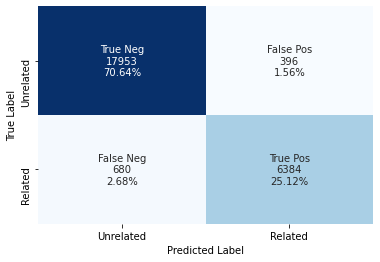

In [17]:
# SVM with linear kernel for TF-IDF cosine similarities
print("SVM - TF-IDF cosine similarities")

# get macro-f1 score over 5-fold cross validation
clf = LinearSVC(class_weight='balanced')
f1_scores = cross_val_score(clf,similarities,labels,cv=5,scoring='f1_macro')
print("Mean F1 score over 5-fold cross validation:",round(100*f1_scores.mean(),2),"%")

# train classifier, measuring training time
clf = LinearSVC(class_weight='balanced')
t0 = time.time()
clf.fit(similarities,labels)
elapsed = format_time(time.time() - t0)
print("Training time:", elapsed)

# report performance on test set
print("on test set...")
predictions = clf.predict(test_similarities)
plot_matrix(test_labels,predictions)

SVM - TF-IDF
Mean F1 score over 5-fold cross validation: 85.28 %
Training time: 0:00:01
on test set...
Accuracy: 53.08 %
F1 Score: 50.83 %


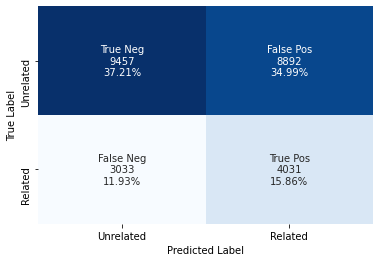

In [18]:
# SVM with linear kernel for TF-IDF
print("SVM - TF-IDF")

# get macro-f1 score over 5-fold cross validation
clf = LinearSVC(class_weight='balanced')
f1_scores = cross_val_score(clf,tf_examples,shuffled_labels,cv=5,scoring='f1_macro')
print("Mean F1 score over 5-fold cross validation:",round(100*f1_scores.mean(),2),"%")

# train classifier, measuring training time
clf = LinearSVC()
t0 = time.time()
clf.fit(tf_examples,shuffled_labels)
elapsed = format_time(time.time() - t0)
print("Training time:", elapsed)

# report performance on test set
print("on test set...")
predictions = clf.predict(tf_test_examples)
plot_matrix(test_labels,predictions)

SVM - BERT
Training time: 0:00:02
on test set...
Accuracy: 51.97 %
F1 Score: 47.65 %


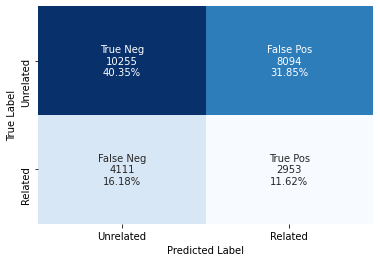

In [19]:
# SVM with linear kernel for BERT embeddings
print("SVM - BERT")

svm_input_ids = [line.tolist()[0] for line in input_ids]
test_input_ids = [line.tolist()[0] for line in test_input_ids]

# train classifier, measuring training time
bert_clf = LinearSVC(dual=False,class_weight='balanced')
t0 = time.time()
bert_clf.fit(svm_input_ids,labels)
elapsed = format_time(time.time() - t0)
print("Training time:", elapsed)

# report performance on test set
print("on test set...")
bert_predictions = bert_clf.predict(test_input_ids)
plot_matrix(test_labels,bert_predictions)

### Related/Unrelated Classification - MLP

MLP - TF-IDF
Iteration 1, loss = 0.48706089
Validation score: 0.834134
Iteration 2, loss = 0.35160228
Validation score: 0.859944
Iteration 3, loss = 0.28948560
Validation score: 0.891156
Iteration 4, loss = 0.24149460
Validation score: 0.902961
Iteration 5, loss = 0.20096728
Validation score: 0.929372
Iteration 6, loss = 0.16714019
Validation score: 0.940376
Iteration 7, loss = 0.13969806
Validation score: 0.947379
Iteration 8, loss = 0.11821463
Validation score: 0.955582
Iteration 9, loss = 0.10121254
Validation score: 0.961985
Iteration 10, loss = 0.08741083
Validation score: 0.970388
Iteration 11, loss = 0.07533852
Validation score: 0.970388
Iteration 12, loss = 0.06666224
Validation score: 0.975190
Iteration 13, loss = 0.05936334
Validation score: 0.976190
Iteration 14, loss = 0.05306770
Validation score: 0.979592
Iteration 15, loss = 0.04778836
Validation score: 0.979792
Iteration 16, loss = 0.04336658
Validation score: 0.979792
Iteration 17, loss = 0.04008815
Validation score: 0.

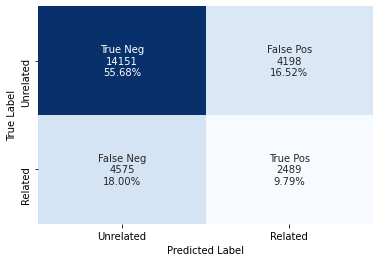

In [20]:
# MLP with TF-IDF
print("MLP - TF-IDF")

# Grid search to find optimal parameters for MLP

#parameters = {'activation': ['logistic','tanh','relu'], 'alpha': [0.00001,0.0001,0.001,0.01], 'learning_rate': ['constant','adaptive'], 'validation_fraction': [0.1,0.2]}
#mlp = MLPClassifier(random_state=42, early_stopping=True, verbose=True, solver='adam', shuffle=True)
#clf = GridSearchCV(mlp, parameters, scoring='f1_macro',verbose=2)

# Initialise and train classifier using best parameters, measuring training time
clf =  MLPClassifier(random_state=42, early_stopping=True, verbose=True, solver='adam', shuffle=True, learning_rate='constant', validation_fraction=0.1, activation='relu', alpha=0.0001)
t0 = time.time()
clf.fit(tf_examples,shuffled_labels)
elapsed = format_time(time.time() - t0)
print("Training time:", elapsed)

# print("Best parameters:")
# print(clf.best_params_)

# report performance on test set
print("on test set...")
predictions = clf.predict(tf_test_examples)
plot_matrix(test_labels,predictions)

### Related/Unrelated Classification - BERT

In [21]:
# Try to use gpu if available
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070


In [22]:
# Combine the training inputs into a TensorDataset.
tensor_dataset = TensorDataset(input_ids_tensor, attention_masks_tensor, labels_tensor)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(tensor_dataset))
val_size = len(tensor_dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(tensor_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

39,977 training samples
9,995 validation samples


In [23]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size
)

In [24]:
logging.set_verbosity_error() # set to warning to show warnings

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
#model.cpu()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [26]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Defining loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
# Defining training epoch of BERT model
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    
  # Measure how long the training epoch takes.
  t0 = time.time()
    
  # Put the model into training mode
  model = model.train()

  losses = []
  correct_predictions = 0
  
  # For each batch of training data...
  for step, batch in enumerate(data_loader):
    
    # Progress update every few batches.
    if step % 200 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
              
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(data_loader), elapsed))
    
    # Unpack this training batch from our dataloader. 
    # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    targets = batch[2].type(torch.LongTensor).to(device)
    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs[0], dim=1)
    loss = loss_fn(outputs[0], targets)

    correct_predictions += torch.sum(preds == targets)
    
    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
    losses.append(loss.item())

    # Perform a backward pass to calculate the gradients.
    loss.backward()
    
    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # Update parameters and take a step using the computed gradient.
    optimizer.step()
    
    # Update the learning rate.
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
  model = model.eval()

  losses = []
  correct_predictions = 0

  # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training).
  with torch.no_grad():
    for batch in data_loader:
        
      # Unpack this validation batch from our dataloader. 
      # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)
      targets = batch[2].type(torch.LongTensor).to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs[0], dim=1)

      loss = loss_fn(outputs[0], targets)

      correct_predictions += torch.sum(preds == targets)
    
      # Accumulate the validation loss
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Epoch 1/2
----------
  Batch   200  of  2,499.    Elapsed: 0:00:41.
  Batch   400  of  2,499.    Elapsed: 0:01:21.
  Batch   600  of  2,499.    Elapsed: 0:02:01.
  Batch   800  of  2,499.    Elapsed: 0:02:42.
  Batch 1,000  of  2,499.    Elapsed: 0:03:23.
  Batch 1,200  of  2,499.    Elapsed: 0:04:04.
  Batch 1,400  of  2,499.    Elapsed: 0:04:44.
  Batch 1,600  of  2,499.    Elapsed: 0:05:25.
  Batch 1,800  of  2,499.    Elapsed: 0:06:06.
  Batch 2,000  of  2,499.    Elapsed: 0:06:47.
  Batch 2,200  of  2,499.    Elapsed: 0:07:28.
  Batch 2,400  of  2,499.    Elapsed: 0:08:09.
Train loss 0.07706430971919281 accuracy 0.9755359331615678
Val   loss 0.017180975257372482 accuracy 0.9957978989494748

Epoch 2/2
----------
  Batch   200  of  2,499.    Elapsed: 0:00:41.
  Batch   400  of  2,499.    Elapsed: 0:01:22.
  Batch   600  of  2,499.    Elapsed: 0:02:02.
  Batch   800  of  2,499.    Elapsed: 0:02:43.
  Batch 1,000  of  2,499.    Elapsed: 0:03:24.
  Batch 1,200  of  2,499.    Elapsed: 0

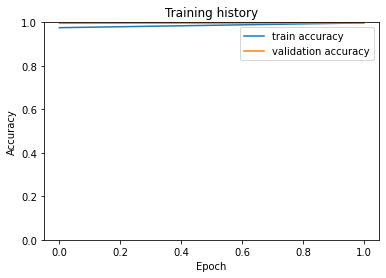

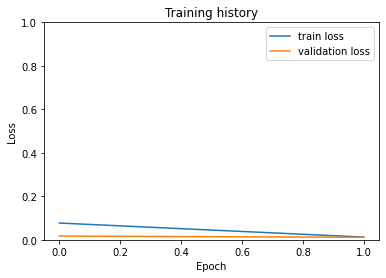

In [29]:
%%time

history = defaultdict(list)
best_accuracy = 0

pretrained = False

if pretrained:
    model.load_state_dict(torch.load('bert.bin'))
    model = model.to(device)
else:
    # Performing training and validation for each epoch
    # Report loss and accuracy
    for epoch in range(epochs):

        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_dataloader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        train_size
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        validation_dataloader,
        loss_fn, 
        device, 
        val_size
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'bert.bin')
            best_accuracy = val_acc

    # Plot the performance of the model over all epochs
    plt.figure(0)
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')

    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);
    
    plt.figure(1)
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')

    plt.title('Training history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);
    

Predicting labels for 25,413 test sentences...
    DONE.
BERT model - BERT embeddings
Accuracy: 98.45 %
F1 Score: 98.07 %


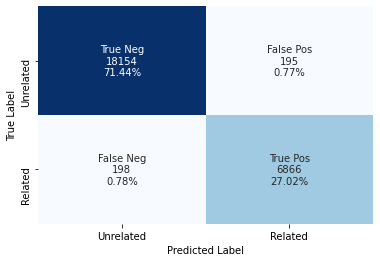

In [30]:
# Create the DataLoader.
prediction_data = TensorDataset(test_input_ids_tensor, test_attention_masks_tensor, test_labels_tensor)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids_tensor)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

print("BERT model - BERT embeddings")
# report performance on test set
plot_matrix(test_labels,flat_predictions)


### Agree/Disagree/Discuss Classification - LSTM

In [31]:
# adding predicted values to test DataFrame
test_data['Predictions'] = flat_predictions

# only keeping data predicted by best model (BERT with BERT) as being related
test_related = test_data[test_data['Predictions']==1]

# Add integer labels column to DataFrame for agree/disagree/discuss classification
test_related['Related_Label'] = test_related.apply (lambda line: related_label(line), axis=1)

test_related['ids'] = test_related.index

test_related_headlines = test_related['Headline']
test_related_bodies = test_related['articleBody']

# Removing stop words from headlines and bodies
new_headlines = []
for line in test_related_headlines.to_list():
    line_words = line.split()
    filtered_words = [word for word in line_words if not word.lower() in stop]
    newline = " ".join(filtered_words)
    new_headlines.append(newline)
test_related_headlines = new_headlines

new_bodies = []
for line in test_related_bodies.to_list():
    line_words = line.split()
    filtered_words = [word for word in line_words if not word.lower() in stop]
    newline = " ".join(filtered_words)
    new_bodies.append(newline)
test_related_bodies = new_bodies

# create instances from headlines and bodies
test_related_examples = [test_related_headlines[i]+" [BRK] "+test_related_bodies[i] for i in range(len(test_related_headlines))]

# adding full examples to dataframe
test_related['Examples'] = test_related_examples

# Inspect DataFrame
display (test_related.head())

,Body ID,articleBody,Headline,Stance,Labels,Predictions,Related_Label,ids,Examples
1,1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree,1,1,0,1,El-Sisi denies claims he'll give Sinai land Pa...
34,2,A bereaved Afghan mother took revenge on the T...,Afghan Mother Kills 25 Taliban Fighters In Sev...,agree,1,1,0,34,Afghan Mother Kills 25 Taliban Fighters Seven-...
107,3,CNBC is reporting Tesla has chosen Nevada as t...,REPORT: Tesla Chooses Nevada For Site Of Its M...,discuss,1,1,2,107,REPORT: Tesla Chooses Nevada Site Massive Batt...
201,12,A 4-inch version of the iPhone 6 is said to be...,4-inch iPhone 6 reported to be in development,discuss,1,1,2,201,4-inch iPhone 6 reported development [BRK] 4-i...
208,19,GR editor’s Note\n\nThere are no reports in th...,Iraqi Army Downs Two British Planes Carrying W...,discuss,1,1,2,208,Iraqi Army Downs Two British Planes Carrying W...


In [32]:
# creating training dataset using related training examples
related = dataset[dataset['Labels']==1]
related_labels = related['Related_Label']
related_headlines = related['Headline']
related_bodies = related['articleBody']
related['ids'] = related.index

In [33]:
# Removing stop words from headlines and bodies
new_headlines = []
for line in related_headlines.to_list():
    line_words = line.split()
    filtered_words = [word for word in line_words if not word.lower() in stop]
    newline = " ".join(filtered_words)
    new_headlines.append(newline)
related_headlines = new_headlines

new_bodies = []
for line in related_bodies.to_list():
    line_words = line.split()
    filtered_words = [word for word in line_words if not word.lower() in stop]
    newline = " ".join(filtered_words)
    new_bodies.append(newline)
related_bodies = new_bodies

related_examples = [related_headlines[i]+" [BRK] "+related_bodies[i] for i in range(len(related_headlines))]

In [34]:
# adding full examples to dataframe
related['Examples'] = related_examples
display (related.head())

,Body ID,articleBody,Headline,Stance,Labels,Related_Label,ids,Examples
24,0,A small meteorite crashed into a wooded area i...,Small Meteorite Strikes in Nicaragua's Capital...,agree,1,0,24,Small Meteorite Strikes Nicaragua's Capital Ci...
36,4,Last week we hinted at what was to come as Ebo...,It Begins: HazMat-Wearing Passenger Spotted At...,discuss,1,2,36,Begins: HazMat-Wearing Passenger Spotted Airpo...
69,5,(NEWSER) – Wonder how long a Quarter Pounder w...,20-Year-Old Quarter Pounder Looks About the Same,discuss,1,2,69,20-Year-Old Quarter Pounder Looks [BRK] (NEWSE...
88,5,(NEWSER) – Wonder how long a Quarter Pounder w...,Two blokes dared to eat 20-year-old burger for...,discuss,1,2,88,Two blokes dared eat 20-year-old burger charit...
93,6,"Posting photos of a gun-toting child online, I...",‘The cub of Baghdadi': ISIS reports its younge...,discuss,1,2,93,‘The cub Baghdadi': ISIS reports youngest jiha...


In [35]:
# setting up 80-20 train-val split
val_size = int(related.shape[0]*0.2)

# shuffle dataset
related = related.sample(frac=1)

# split into new datasets
train = related[val_size:]
val = related[:val_size]

In [36]:
display (train.head())
display (val.head())

,Body ID,articleBody,Headline,Stance,Labels,Related_Label,ids,Examples
17949,1042,The improbable story making the rounds today o...,The Story Of The High School Trader Who Made $...,discuss,1,2,17949,Story High School Trader Made $72 Million Rumo...
38003,2025,With the threat of an ISIS terror attack becom...,Fears Islamic State could launch EBOLA attack ...,discuss,1,2,38003,Fears Islamic State could launch EBOLA attack ...
39896,2106,She is rarely seen without her trademark Chane...,"Rats at Vogue's NYC offices - watch your step,...",discuss,1,2,39896,"Rats Vogue's NYC offices - watch step, Anna Wi..."
42347,2200,A video released by the Islamic State on Tuesd...,New ISIS Video Shows Militants Seizing Weapons...,discuss,1,2,42347,New ISIS Video Shows Militants Seizing Weapons...
34970,1896,Boko Haram has reportedly agreed to a cease-fi...,Nigeria says ceasefire agreed with Boko Haram,discuss,1,2,34970,Nigeria says ceasefire agreed Boko Haram [BRK]...


,Body ID,articleBody,Headline,Stance,Labels,Related_Label,ids,Examples
39876,2106,She is rarely seen without her trademark Chane...,"In Vogue vs Rats War, the Rats Are Winning",discuss,1,2,39876,"Vogue vs Rats War, Rats Winning [BRK] rarely s..."
7955,505,"Omar Gonzalez, the White House fence-jumper fr...",Report: Secret Service Lied About White House ...,discuss,1,2,7955,Report: Secret Service Lied White House Fence ...
18771,1109,The first group of mass graves excavated on th...,"Mass Graves Found In Mexico, Near Place Where ...",discuss,1,2,18771,"Mass Graves Found Mexico, Near Place 43 Studen..."
31278,1743,The duped mum ate her son - after being told i...,Isis 'fed murdered kidnap victim to his own mo...,discuss,1,2,31278,Isis 'fed murdered kidnap victim mother travel...
35254,1905,NEW YORK — Pope Francis has given hope to gays...,Pope Francis turns out not to have made pets i...,disagree,1,1,35254,Pope Francis turns not made pets heaven commen...


In [37]:
# truncate data
truncate_to = 100

def truncate(data):
    data = data.split()[:truncate_to]
    return ' '.join(data)


In [38]:
# save DataFrame as csv
def df_to_csv(df, filename):
    
    # truncate and save appropriate data to csv file
    data = df.filter(['Related_Label','Headline','articleBody','Examples'], axis=1)
    data['Examples'] = data['Examples'].apply(truncate)
    data.columns = ['label', 'title', 'text', 'alltext']
    data['text'] = data['text'].apply(truncate)
    data = data.reindex(columns=['label', 'title', 'text', 'alltext'])
    
    data.to_csv(filename, index=False)

In [39]:
df_to_csv(train, 'train.csv')
df_to_csv(val, 'val.csv')
df_to_csv(test_related, 'test.csv')

In [40]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='./',train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
lstm_batch_size = 32

train_iter = BucketIterator(train, batch_size=lstm_batch_size, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=lstm_batch_size, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=lstm_batch_size, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=10,vectors=GloVe(name='6B', dim=300))

In [144]:
# define structure of LSTM network and forward function
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension

        self.lstm1 = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            dropout=0.2,
                            batch_first=True,
                            bidirectional=True)
        
        self.lstm2 = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            dropout=0.2,
                            batch_first=True,
                            bidirectional=True)
        
        self.drop = nn.Dropout(p=0.3)
        
        self.fc = nn.Linear(4*dimension, 3)

    def forward(self, title, title_len, text, text_len):
        
        title_emb = self.embedding(title)
        text_emb = self.embedding(text)

        title_output, last_hidden = self.lstm1(title_emb)
        
        all_output, _ = self.lstm2(text_emb,last_hidden)
        
        title_out_forward = title_output[range(len(title_output)), title_len - 1, :self.dimension]
        title_out_reverse = title_output[:, 0, self.dimension:]
        title_out_reduced = torch.cat((title_out_forward, title_out_reverse), 1)
        
        text_out_forward = all_output[range(len(all_output)), text_len - 1, :self.dimension]
        text_out_reverse = all_output[:, 0, self.dimension:]
        text_out_reduced = torch.cat((text_out_forward, text_out_reverse), 1)
        
        both = torch.cat((title_out_reduced, text_out_reduced),1)
        
        text_features = self.drop(both)
        text_features = self.fc(text_features)
        text_out = torch.sigmoid(text_features)

        return text_out

In [145]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [146]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = '.',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (alltext, alltext_len)), _ in train_loader:
            oh = torch.zeros(labels.shape[0],3)
            for x in range(labels.shape[0]):
                if labels[x] == 0:
                    oh[x,0] = 1
                if labels[x] == 1:
                    oh[x,1] = 1
                if labels[x] == 2:
                    oh[x,2] = 1

            labels = oh.to(device)
            title = title.to(device)
            title_len = title_len.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(title, title_len, text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (title, title_len), (text, text_len), (alltext, alltext_len)), _ in valid_loader:
                    oh = torch.zeros(labels.shape[0],3)
                    for x in range(labels.shape[0]):
                        if labels[x] == 0:
                            oh[x,0] = 1
                        if labels[x] == 1:
                            oh[x,1] = 1
                        if labels[x] == 2:
                            oh[x,2] = 1

                    labels = oh.to(device)
                    title = title.to(device)
                    title_len = title_len.to(device)
                    text = text.to(device)
                    text_len = text_len.to(device)
                    output = model(title, title_len, text, text_len)

                    loss = criterion(output, labels)
                    valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [153]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

t0 = time.time()
train(model=model, optimizer=optimizer, num_epochs=10)
elapsed = format_time(time.time() - t0)
print("Training time:", elapsed)

Epoch [1/10], Step [168/3360], Train Loss: 0.3793, Valid Loss: 0.3823
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [1/10], Step [336/3360], Train Loss: 0.3004, Valid Loss: 0.2667
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [2/10], Step [504/3360], Train Loss: 0.2192, Valid Loss: 0.2075
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [2/10], Step [672/3360], Train Loss: 0.1385, Valid Loss: 0.1946
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [3/10], Step [840/3360], Train Loss: 0.1133, Valid Loss: 0.1380
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [3/10], Step [1008/3360], Train Loss: 0.0882, Valid Loss: 0.1293
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [4/10], Step [1176/3360], Train Loss: 0.0709, Valid Loss: 0.1242
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [4/10], Step [1344/3360], Train Loss: 0.0680, Valid Loss: 0.1189
Mod

Model loaded from <== ./metrics.pt


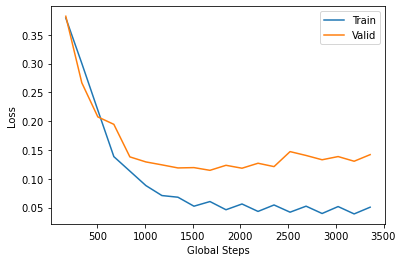

In [154]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('./metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [155]:
# Evaluation Function

def evaluate(model, test_loader, threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (alltext, alltext_len)), _ in test_loader:
            
            title = title.to(device)
            title_len = title_len.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(title, title_len, text, text_len)

            y_pred.extend(torch.argmax(output, dim=1).tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1,2,3], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Agree', 'Disagree', 'Discuss', 'Unrelated'])
    ax.yaxis.set_ticklabels(['Agree', 'Disagree', 'Discuss', 'Unrelated'])
    
    return y_true, y_pred

Model loaded from <== ./model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.4237    0.6444    0.5112      1856
           1     0.0526    0.0015    0.0030       657
           2     0.7589    0.7356    0.7471      4353
           3     0.0000    0.0000    0.0000       195

    accuracy                         0.6230      7061
   macro avg     0.3088    0.3454    0.3153      7061
weighted avg     0.5841    0.6230    0.5952      7061



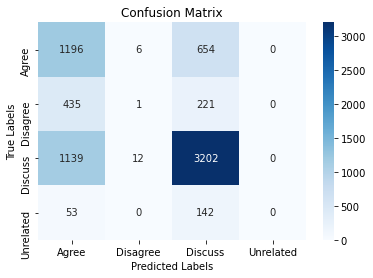

In [156]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('./model.pt', best_model, optimizer)
y_true, y_pred = evaluate(best_model, test_iter)

### Overall Performance

In [157]:
# calculating fnc metric used by organisers of challenge
def fnc_score(y_true,y_pred):
    score = 0
    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_label = y_pred[i]
        # add to score if correctly classified
        if true_label==pred_label:
            score+=0.25
            # add to score if related
            if true_label!=3:
                score+=0.5
        # add to score if correctly classified as related 
        if true_label<3 and pred_label<3:
            score+=0.25
    return score

Classification Report:
              precision    recall  f1-score   support

           0     0.4237    0.6285    0.5061      1903
           1     0.0526    0.0014    0.0028       697
           2     0.7589    0.7173    0.7375      4464
           3     0.9892    0.9894    0.9893     18349

    accuracy                         0.8875     25413
   macro avg     0.5561    0.5841    0.5589     25413
weighted avg     0.8807    0.8875    0.8818     25413

Accuracy: 88.75 %
Macro F1 Score: 55.89 %
FNC Score: 9554.25 out of 11651.25 (82.0%)


[Text(0, 0.5, 'Agree'),
 Text(0, 1.5, 'Disagree'),
 Text(0, 2.5, 'Discuss'),
 Text(0, 3.5, 'Unrelated')]

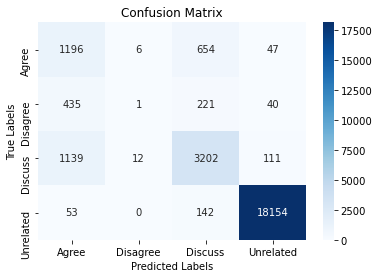

In [158]:
# examine unrelated data to get overall results
test_unrelated = test_data[test_data['Predictions']==0]
test_unrelated['Related_Label'] = test_unrelated.apply (lambda line: related_label(line), axis=1)
true_labels = test_unrelated['Related_Label'].tolist()
predicted_labels = [3]*test_unrelated.shape[0]

# combine all results
all_true = y_true+true_labels
all_predicted = y_pred+predicted_labels

# display results
print('Classification Report:')
print(classification_report(all_true, all_predicted, labels=[0,1,2,3], digits=4))

print("Accuracy:",round(100*accuracy_score(all_true,all_predicted),2),"%")
print("Macro F1 Score:",round(100*f1_score(all_true,all_predicted,average='macro'),2),"%")
score = fnc_score(all_true,all_predicted)
best_score = fnc_score(all_true,all_true)
print("FNC Score:",str(score),"out of",str(best_score),"("+str(round(score*100/best_score,2))+"%)")
    
cm = confusion_matrix(all_true, all_predicted, labels=[0,1,2,3])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['Agree', 'Disagree', 'Discuss', 'Unrelated'])
ax.yaxis.set_ticklabels(['Agree', 'Disagree', 'Discuss', 'Unrelated'])